<a href="https://colab.research.google.com/github/celinagacias/dc-symmetron/blob/main/Data%20Cleaning%20and%20Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
from datetime import datetime
import re

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth, drive
from oauth2client.client import GoogleCredentials

# Data Read-In

In [ ]:
#Authenticate user
auth.authenticate_user()
gauth = GoogleAuth()

#Mount GDrive
gdrive = GoogleDrive(gauth)
gauth.credentials = GoogleCredentials.get_application_default()
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Read data from csv
folder = '1iLA5sSyu7ere1AN40TWRf6O6ma5LoIDl'
filename = 'raw_AACT_data.csv'

gfile_list = gdrive.ListFile({'q': "'" +  folder + "'" + " in parents and trashed=false"}).GetList()
gfile = [f for f in gfile_list if f['title'] == filename][0]
df_file = gdrive.CreateFile({'id': gfile['id']})
df_file.GetContentFile(gfile['title'])
df = pd.read_csv(filename)
display(df.head(2))

,nct_id,start_date,start_date_type,study_type,phase,overall_status,last_known_status,population,gender_description,minimum_age,maximum_age,gender,healthy_volunteers,countries_removed,countries_retained,conditions_table,mesh_term,criteria
0,NCT00000113,1997-09-30,NaN,Interventional,Phase 3,Completed,NaN,NaN,NaN,6 Years,12 Years,All,No,{},"{""United States""}",myopia,"eye diseases, refractive errors, myopia",Children between the ages of 6 and 12 years wi...
1,NCT00000114,1984-05-31,NaN,Interventional,Phase 3,Completed,NaN,NaN,NaN,18 Years,49 Years,All,NaN,NaN,NaN,retinitis pigmentosa,"retinitis, eye diseases, hereditary, retinal d...",Men and nonpregnant women between ages 18 and ...


In [ ]:
n = len(df)
print(f'There are {n} studies in our sample.')

There are 42275 studies in our sample.


# Data Cleaning

## Dates

In [ ]:
# convert start date to date
df['start_date'] = df['start_date'].apply(
    lambda x: datetime.strptime(x, '%Y-%m-%d').date() if str(x) != 'nan' else None)

In [ ]:
# extract year into separate column
df['start_year'] = df['start_date'].apply(lambda x: int(x.year) if x is not None else None)

## Countries

In [ ]:
def process_countries(l):
  # converts string of list of countries into lists
  l = l.replace('{','').replace('}','').split(',')
  l = set([c.replace('"','') for c in l])
  return l

In [ ]:
# apply the function to each list of countries
df['countries_removed'] = df['countries_removed'].apply(
    lambda x: process_countries(x) if str(x) != 'nan' else None)

df['countries_retained'] = df['countries_retained'].apply(
    lambda x: process_countries(x) if str(x) != 'nan' else None)

## Ages

In [ ]:
def parse_age(a):
  # Convert text of age into years
  if str(a) == 'nan':
    return np.nan

  num = int(str(a).split(' ')[0])
  if 'Year' in a:
    age = num
  elif 'Month' in a:
    age = num / 12
  elif 'Week' in a:
    age = num / 52
  elif 'Day':
    age = num / 365
  elif 'Hour' in a:
    age = num / (24 * 365)
  elif 'Minute' in a:
    age = num / (24 * 365 * 60)
  return age

df['minimum_age'] = df['minimum_age'].apply(parse_age)
df['maximum_age'] = df['maximum_age'].apply(parse_age)

## Inclusion/Exclusion Criteria

In [ ]:
# identify which studies have clear inclusion vs. exclusion
df['criteria_norm'] = df.criteria.fillna('').str.upper().str.strip().str.replace(' CRITERIA','')
inc_cond = df.criteria_norm.str.contains('INCLUSION:')
exc_cond = df.criteria_norm.str.contains('EXCLUSION:')
parse_mask = (inc_cond) & (exc_cond)
len_parse = df[parse_mask].shape[0]
print(f'There are {len_parse} ({np.round(len_parse*100/n, 2)}%) studies with clearly delineated inclusion/exclusion criteria')

There are 38208 (90.38%) studies with clearly delineated inclusion/exclusion criteria


In [ ]:
def parse_criteria(c):
  '''Splits criteria into inclusion and exclusion'''

  def clean_criteria(s):
    # sub-function to clean up criteria text
    s = s.replace('INCLUSION:','').strip() # remove inclusion title
    s = re.sub(r'(\n\s*)+\n+', '\n', s) # reduce newlines
    return s

  # create list with [inclusion, exclusion]
  c_list = c.split('EXCLUSION:')
  c_list = [clean_criteria(s) for s in c_list]
  return c_list

# apply the function to derive inclusion and exclusion
df['inclusion'] = None
df['exclusion'] = None
df.loc[parse_mask, 'criteria_split'] = df.loc[parse_mask, 'criteria_norm'].apply(parse_criteria)
df.loc[parse_mask, 'inclusion'] = df.loc[parse_mask, 'criteria_split'].apply(lambda x: x[0])
df.loc[parse_mask, 'exclusion'] = df.loc[parse_mask, 'criteria_split'].apply(lambda x: x[1])

## Subsetting

In [ ]:
# remove studies that were paused or suspended
suspend_mask = (df.overall_status.isin(['Terminated', 'Withdrawn', 'Suspended']))
n_suspend = df[suspend_mask].shape[0]
print(f'There are {n_suspend} studies that need to be removed because they are either terminated, withdrawn, or suspended.')
df = df[~suspend_mask].copy(deep=True)
print(f'There are {len(df)} studies remaining.')

There are 4597 studies that need to be removed because they are either terminated, withdrawn, or suspended.
There are 37678 studies remaining.


# Initial Analysis

## By Age

Perform analysis of excluded age groups

In [ ]:
def get_ages(min, max):
  reference_ages = set( range(0, 101) )
  if str(min) != 'nan' and str(max) != 'nan':
    inc = set( range( int(min), int(max)+1 ) )
  elif str(min) == 'nan' and str(max) != 'nan':
    inc = set( range(0, int(max)+1 ) )
  elif str(min) != 'nan' and str(max) == 'nan':
    inc = set( range( int(min), 101) )
  else:
    inc = reference_ages
  exc = sorted(list(reference_ages - inc))
  return exc

df['excluded_ages'] = df.apply(lambda x: get_ages(x.minimum_age, x.maximum_age), axis=1) 

display( df[['minimum_age', 'maximum_age', 'excluded_ages']] )

,minimum_age,maximum_age,excluded_ages
0,6.0,12.0,"[0, 1, 2, 3, 4, 5, 13, 14, 15, 16, 17, 18, 19,..."
1,18.0,49.0,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,..."
2,18.0,56.0,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,..."
3,NaN,50.0,"[51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 6..."
4,NaN,NaN,[]
...,...,...,...
42270,18.0,65.0,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,..."
42271,18.0,80.0,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,..."
42272,20.0,70.0,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,..."
42273,18.0,64.0,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,..."


There are 1511 clinical trials for digestive system.
There are 1003 clinical trials for breast.
There are 926 clinical trials for lymphoproliferative.
There are 925 clinical trials for immunoproliferative.
There are 855 clinical trials for respiratory.
There are 684 clinical trials for lymphatic.
There are 593 clinical trials for leukemia.
There are 529 clinical trials for head and neck.


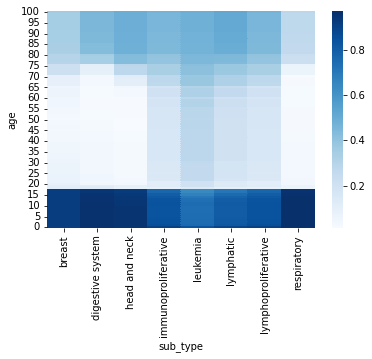

In [ ]:
# obtain subset of cancer studies
cancer = df[(df.mesh_term.str.contains('neoplasm')) | (df.mesh_term.str.contains('cancer'))].copy(deep=True)

# for obtaining the "exclusion rate" per age from 0-100 based on a search term
search_term = 'digestive system'
def count_age_exclude(search_term, cancer=cancer):

  def count_trials(sub, age):
    where_excluded = sub[sub.excluded_ages.apply(lambda x: age in x)]
    no_excluded = len(where_excluded)
    return no_excluded

  sub = cancer[cancer.mesh_term.str.contains(search_term)].copy(deep=True)
  n = len(sub)
  print(f'There are {n} clinical trials for {search_term}.')
  ages = list( range(0,101) )
  percent_trials = [count_trials(sub, age)/n for age in ages]
  result = pd.DataFrame({
    'age': ages,
    'sub_type': [search_term] * len(ages),
    'percent_trials': percent_trials
  })
  return result

# for obtaining the same thing for multiple search terms
search_terms = sorted(['respiratory', 'lymphoproliferative', 'lymphatic', 'leukemia', 'immunoproliferative', 'head and neck', 'digestive system', 'breast'],
key=lambda x: -len(cancer[cancer.mesh_term.str.contains(x)]))
tables = [count_age_exclude(term) for term in search_terms]
lt = pd.concat(tables)

# pivot from long to wide
lt_wide = pd.pivot(lt, index='age', columns = 'sub_type', values = 'percent_trials')
lt_wide.sort_values('age', ascending=False, inplace=True)

import seaborn as sns

sns.heatmap(lt_wide, cmap="Blues")

## By Gender

Simple descriptive statistics of gender column:

In [ ]:
# Overall gender percentages across all cancer groups:
gender_percentages_overall = df.gender.value_counts(normalize=True) * 100
gender_percentages_overall

Gender proportions by cancer type: 

In [ ]:
search_terms = ['digestive system neoplasm', 'respiratory tract neoplasm', 'head and neck neoplasm']

def obtain_gender_percent(term, df=df):
  # obtain subset of trials with search term
  mask = df.mesh_term.fillna('').str.contains(term)
  sub = df[mask].copy(deep=True)
  gender_prop = sub['gender'].value_counts(normalize = True) * 100

  # summarize gender percent
  table = pd.DataFrame(gender_prop).reset_index()
  table.rename(columns={'index': 'gender', 'gender': 'percent'}, inplace=True)
  table['condition'] = term
  return table

percent_tables = [obtain_gender_percent(term) for term in search_terms]
percent_all = pd.concat(percent_tables)
percent_all

In [ ]:
raise Exception("scratch code below")

Exception: ignored